# Basic crowdsourced report statistics
#### Here, different statistics regarding the crowdsourced hail reports are calculated and shown

In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import patheffects
import xarray as xr
import datetime as dt
import cartopy.crs as ccrs
from climada import CONFIG
import scClim as sc
import seaborn as sns

data_dir = str(CONFIG.local_data.data_dir)
out_dir = str(CONFIG.local_data.out_dir)

In [2]:
#Load crowdsourced data
str_cols = ['OsVersion','AppVersion','Language','size_text','size_text_new']
crowd_data = pd.read_csv(f'{data_dir}/crowd-source/crowd_processed_paper.csv',
                         parse_dates=['time_dt','hailday'],dtype={v:str for v in str_cols})
crowd_data['hailday'] = crowd_data.hailday.dt.date # Convert datetime to date
crowd_data['hour_CEST'] = (crowd_data['hour'] + 2) % 24 # Convert hours from UTC to CEST (UTC+2)

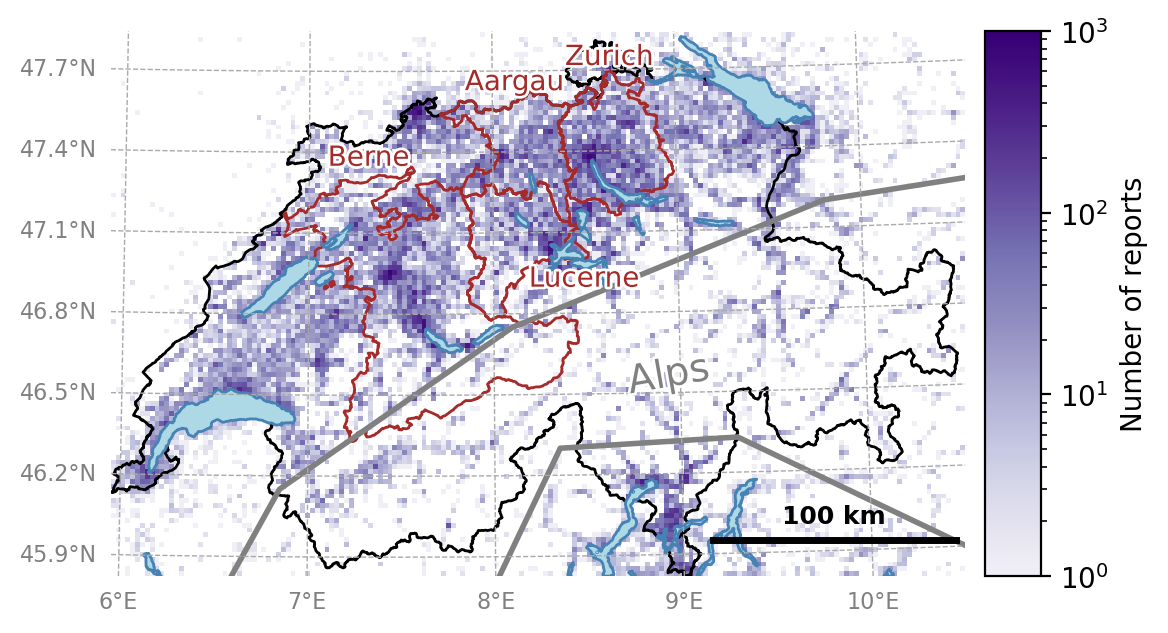

In [3]:
#Remove all entries before (and including) July 2020 (and only April-September)
crowd_sel = crowd_data[crowd_data.hailday.apply(pd.Timestamp).dt.date >= dt.date(2020,8,1)]
crowd_sel = crowd_sel[crowd_sel.hailday.apply(pd.Timestamp).dt.month.isin([4,5,6,7,8,9])]
crowd_sel = crowd_sel.loc[crowd_sel.size_text!='No hail']
fig, ax = sc.plot_funcs.plot_crowdsourced_overview(crowd_sel,res_km=2)
ax.axis('off')
fig.savefig(out_dir+'/paper_crowd/fig_overview.png',bbox_inches='tight',dpi=300)

<Axes: xlabel='Hour of the day [CEST]', ylabel='Number of reports [density]'>

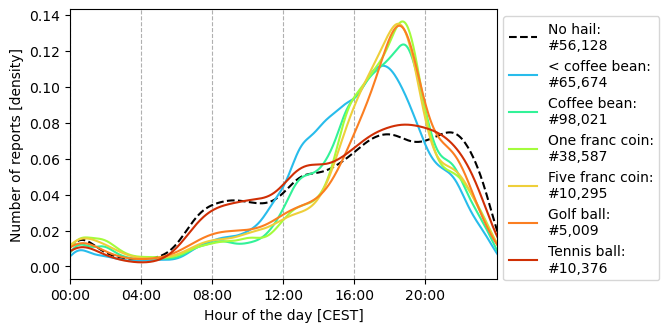

In [4]:
#Plot temproal distribution of hail reports regarding the hour of the day
fig, ax = plt.subplots(figsize=(5.5,3.5))
def plot_diurnal(crowd_data,ax,legend_kws={}):
    size_categories = crowd_data.sort_values('size',ascending=True).size_text.unique()
    size_categories = size_categories[size_categories != "Old size category"]

    #Loop over size cateogries
    for size_text in size_categories:
        if size_text != "Old size category":
            #get color values
            if size_text == 'No hail':
                color = 'black'
                ls = '--'
            else:
                color = sns.color_palette("turbo",len(size_categories))[list(size_categories).index(size_text)]
                ls = '-'
            label = f"{size_text}:\n#{crowd_data.loc[crowd_data.size_text == size_text,:].shape[0]:,d}"
            crowd_data.loc[crowd_data.size_text == size_text,:].hour_CEST.plot.kde(label=label,color=color,ls=ls,ax=ax)

    #Set plot parameters
    _=ax.set(xticks=np.arange(0, 24, 4),xlim=[0,24],xticklabels=["00:00","04:00","08:00","12:00","16:00","20:00"],
            xlabel='Hour of the day [CEST]',ylabel='Number of reports [density]')
    ax.grid(axis='y', linestyle='--', alpha=0)
    ax.grid(axis='x', linestyle='--', alpha=1)

    ax.legend(**legend_kws)
    return ax
plot_diurnal(crowd_data,ax,legend_kws={'loc':'upper left','bbox_to_anchor':(1.0,1.0)})


In [5]:
#Calculate the fraction of reports between 00:00 and 04:00 UTC (2:00 and 6:00 CEST)
n_reps = crowd_data.hour_int.value_counts().sort_index()
frac_0t4=n_reps.loc[0:3].sum()/n_reps.sum()
print(f" {frac_0t4*100:.2f}% of reports are between 00:00 and 04:00 UTC")

 1.98% of reports are between 00:00 and 04:00 UTC


## Analysis of tennis ball reports

In [6]:
#define function to plot grouped bar plots
def plot_x_events(crowd_data,ax,column_name,grpy='hailday',agg='sum',
                  n_largest=None,relative=False,col_order=None,**kwargs):
    """Plot grouped bar plots of hail reports based on different filters.

    Args:
        crowd_data (pd.DataFrame): crowd-sourced hail reports.
        ax (plt.Axes): axes to plot
        column_name (str): Column to count data points.
        grpy (str, optional): Column by which to group data. Defaults to 'hailday'.
        agg (str, optional): Aggregation statistic. Defaults to 'sum'.
        n_largest (int, optional): If not None, only plot n largest groups.
                                    Defaults to None.
        relative (bool, optional): Whether to plot absolute or relative values.
        col_order (list, optional): If specified, prescribe a column order.
    """
    #group data based on grpy and calculate aggregation
    all_reports = crowd_data.groupby(grpy)[column_name].agg(agg)
    flag1 = crowd_data[crowd_data.Flag_CZC==0].groupby(grpy)[column_name].agg(agg).reindex(all_reports.index)
    flag2 = crowd_data[crowd_data.maxBZC_t15_r4>0].groupby(grpy)[column_name].agg(agg).reindex(all_reports.index)
    flag3 = crowd_data[crowd_data.maxMZC_t15_r4>0].groupby(grpy)[column_name].agg(agg).reindex(all_reports.index)

    #select index of n_largest values (based on all reports)
    if n_largest is not None:
        sel_idx = all_reports.nlargest(n_largest).index

    # loop over increasing restrictive filters
    for data,label,color in zip([all_reports,flag1,flag2,flag3],
                                ['all hail reports','Max. reflectivity\nfilter','POH filter','MESHS filter'],
                                ['none','grey','lightgreen','tab:green']):
        edgecolor = 'black' if label == 'all hail reports' else 'none'
        zorder = 2 if label == 'all hail reports' else 1
        if relative:
            data = data/all_reports
        if n_largest is not None:
            data = data[sel_idx]
        elif col_order is not None:
            data = data[col_order]
        # plot data
        data.plot(kind='bar',label=label,color=color,ax=ax,edgecolor=edgecolor,zorder=zorder,**kwargs)

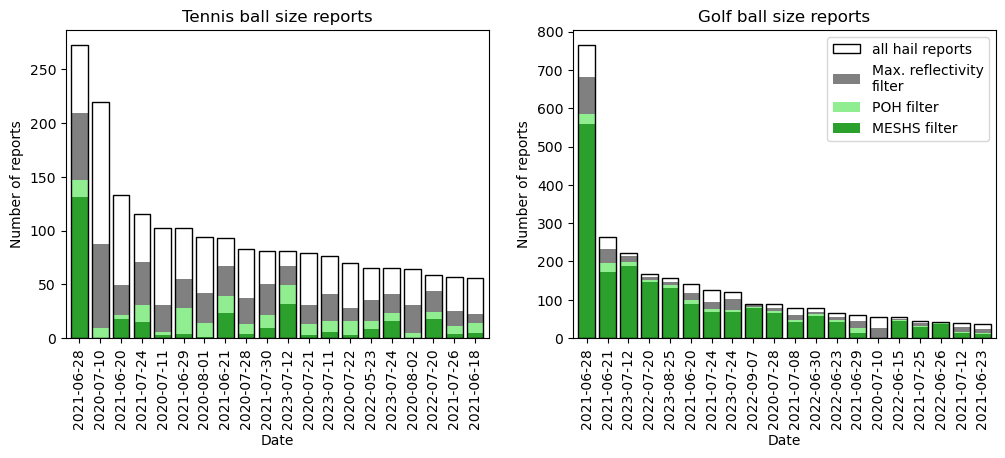

In [7]:
#Define boolean columns for tennis and golf ball reports
crowd_data['tennis_ball_report'] = crowd_data['size']==16
crowd_data['golf_ball_report'] = crowd_data['size']==15


# Plot tennis and golf ball reports
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
plot_x_events(crowd_data,ax1,'tennis_ball_report',width=0.8,n_largest=20)
plot_x_events(crowd_data,ax2,'golf_ball_report',width=0.8,n_largest=20)
for ax in [ax1,ax2]:
    ax.set(xlabel='Date',ylabel='Number of reports')
ax1.set(title= 'Tennis ball size reports')
ax2.set(title= 'Golf ball size reports')
ax2.legend()

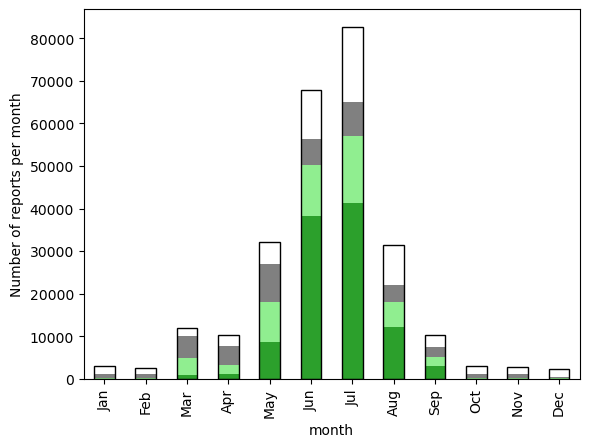

In [10]:
#Plot monthly distribution of hail reports
crowd_data['month'] = crowd_data.time_dt.dt.month
fig,ax = plt.subplots()
plot_x_events(crowd_data[~crowd_data.no_hail],ax,'ID',grpy='month',agg='count',relative=False,col_order=np.arange(1,12+1))#,n_largest=None,col_order=np.arange(1,12+1))#,col_order=col_order)
_=ax.set(ylabel="Number of reports per month",
         xticklabels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

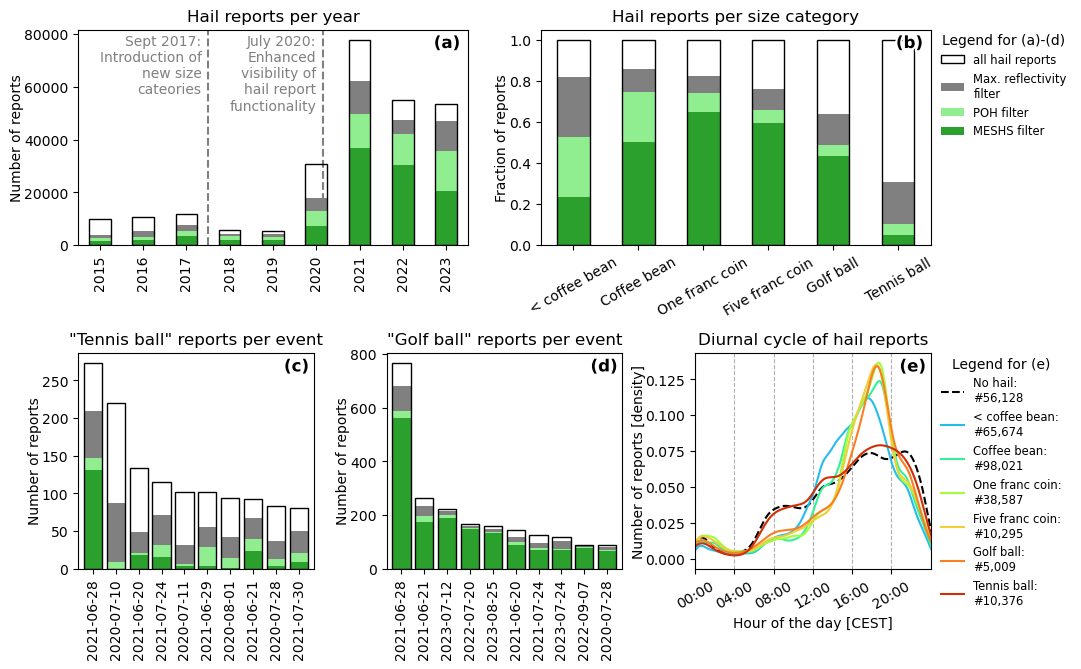

In [13]:
#Create combined figure
fig = plt.figure(figsize=(11,7))
gs = GridSpec(2, 6, figure=fig, height_ratios=[1, 1], hspace=0.5, wspace=0.9)

# Top row: 2 plots that each span 3 columns
axt1 = fig.add_subplot(gs[0, :3])
axt2 = fig.add_subplot(gs[0, 3:])
ax1 = fig.add_subplot(gs[1, :2])
ax2 = fig.add_subplot(gs[1, 2:4])
ax3 = fig.add_subplot(gs[1, 4:6])
axes = np.array([[axt1, axt2, ax1, ax2,ax3]])

#Hail reports per year
plot_x_events(crowd_data[~crowd_data.no_hail],axt1,'ID',grpy='year',agg='count',relative=False,n_largest=None)
axt1.axvline(2.5,color='grey',ls='--')
y0=80_000
axt1.text(2.35,y0,'Sept 2017:\nIntroduction of\nnew size\ncateories',ha='right',va='top',color='grey')
axt1.axvline(5.15,color='grey',ls='--',zorder=0)
axt1.text(5.0,y0,'July 2020:\nEnhanced\nvisibility of\nhail report\nfunctionality',
          ha='right',va='top',color='grey')
axt1.set(ylabel='Number of reports',title='Hail reports per year',xlabel='')

#Plot diurnal cycle
lgd_kws = {'fontsize':'small','loc':'upper left','bbox_to_anchor':(1,1.03),
           'title':'Legend for (e)','frameon':False}
plot_diurnal(crowd_data,ax3,legend_kws=lgd_kws)
ax3.set_title('Diurnal cycle of hail reports')

#Distribution per size category
col_order = crowd_data.sort_values("size").size_text.unique()[2:]
plot_x_events(crowd_data,axt2,'ID',grpy='size_text',agg='count',relative=True,n_largest=None,col_order=col_order)
axt2.set(ylabel="Fraction of reports",xlabel="")
axt2.set(title='Hail reports per size category')

#Plot largest events for tennis and golf ball size reports
plot_x_events(crowd_data,ax1,'tennis_ball_report',width=0.8,n_largest=10)
plot_x_events(crowd_data,ax2,'golf_ball_report',width=0.8,n_largest=10)

for ax in [axt2,ax3]:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)#, ha='right')

# Set plot parameters
for ax in [ax1,ax2]:
    ax.set(ylabel='Number of reports',xlabel="")
ax1.set(title= '"Tennis ball" reports per event')
ax2.set(title= '"Golf ball" reports per event')

#Main legend
axt2.legend(loc='upper left',bbox_to_anchor=(1,1.03),frameon=False,
            fontsize='small',title='Legend for (a)-(d)')



labels = ['(a)','(b)','(c)','(d)','(e)']
for ax,lbl in zip(axes.flatten(),labels):
    txt = ax.text(0.98,0.97,f"{lbl}", transform=ax.transAxes,ha='right',
                va='top',fontsize=12,weight='bold')
    txt.set_path_effects([patheffects.withStroke(linewidth=3, foreground='w')])

    #set y-labelpads to zero
    ax.yaxis.labelpad = 0

fig.savefig(f'{out_dir}/paper_crowd/reports_overview_V2.png',dpi=300,bbox_inches='tight')